# Here we explore the use of TIGRAMITE to discover causal relationships in time series data!

TIGRAMITE is a time series analysis python module, authored by Jakob Runge et al.. It allows us to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on the PCMCI framework and create high-quality plots of the results. This notebook draws heavily on a Tigramite tutorial - we acknowledge this. Citation:  J. Runge (2018): Causal Network Reconstruction from Time Series: From Theoretical Assumptions to Practical Estimation. Chaos: An Interdisciplinary Journal of Nonlinear Science 28 (7): 075310. https://aip.scitation.org/doi/10.1063/1.5025050

In [ ]:
!pip -q install tigramite
!pip -q install dcor

In [ ]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
import dcor

Consider time series coming from a data generating process

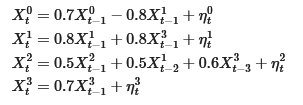

Where we have independent zero-mean unit variance random variables. Our goal is to reconstruct the drivers of each variable. In Tigramite such a process can be generated with the function toys.var_process.

In [ ]:
np.random.seed(42)     # Fix random seed
links_coeffs = {0: [((0, -1), 0.7), ((1, -1), -0.8)],
                1: [((1, -1), 0.8), ((3, -1), 0.8)],
                2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                3: [((3, -1), 0.4)],
                }
T = 1000     # time series length
data, true_parents_neighbors = toys.var_process(links_coeffs, T=T)
T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
dataframe = pp.DataFrame(data, 
                         datatime = np.arange(len(data)), 
                         var_names=var_names)

data

array([[  0.49671415,   1.39935544,  -0.67517827,  -1.90780756],
       [ -0.1382643 ,   0.92463368,  -0.14451867,  -0.86038501],
       [  0.64768854,   0.05963037,  -0.79241992,  -0.41360553],
       ...,
       [-10.90004356,   2.44106964,   4.77902446,   0.04227008],
       [ -7.94392568,   2.89469444,   3.53940947,   2.2267637 ],
       [ -7.54950901,   3.26204201,   4.74298747,   2.96848306]])

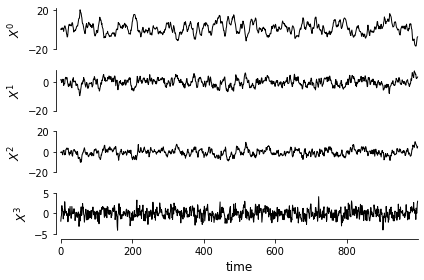

In [ ]:
tp.plot_timeseries(dataframe)
plt.show()

Next, we choose a conditional independence test, here we start with ParCorr implementing linear partial correlation. With significance='analytic' the null distribution is assumed to be Student's $t$. Then we initialize the PCMCI method with dataframe, and cond_ind_test:

In [ ]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)

Before running the causal algorithm, it's a good idea to plot the lagged unconditional dependencies, e.g., the lagged correlations. This can help to identify which maximal time lag tau_max to choose in the causal algorithm.


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


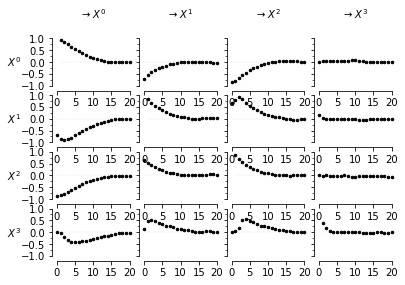

In [ ]:
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

Since the dependencies decay beyond a maximum lag of around 8, we choose tau_max=8 for PCMCI. The other main parameter is pc_alpha which sets the significance level in the condition-selection step. Here we let PCMCI choose the optimal value by setting it to pc_alpha=None. Then PCMCI will optimize this parameter in the ParCorr case by the Akaike Information criterion among a reasonable default list of values (e.g., pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]). The parameter alpha_level=0.01 indicates that we threshold the resulting p-value matrix at this significance level to obtain the graph.

In [ ]:
pcmci.verbosity = 1
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None, alpha_level=0.01)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X^0$ has 7 link(s):
    [pc_alpha = 0.3]
        ($X^0$ -1): max_pval = 0.00000, min_val =  0.796
        ($X^1$ -1): max_pval = 0.00000, min_val = -0.748
        ($X^3$ -2): max_pval = 0.13715, min_val =  0.048
        ($X^3$ -1): max_pval = 0.19326, min_val = -0.042
        ($X^2$ -1): max_pval = 0.20477, min_val = -0.041
        ($X^3$ -7): max_pval = 0.25822, min_val =  0.036
        ($X^1$ -4): max_pval = 0.26548, min_val =  0.036

    Variable $X^1$ has 4 link(s):
    [pc_alpha = 0.3]
        ($X^1$ -1): max_pval = 0.00000, min_val =  0.695
        ($X^3$ -1): max_pval = 0.00000, min_val =  0.484
        ($X^3$ -7): max_pval = 0.14660, min_val =  0.046
        ($X^2$ -1): max_pval = 0.22144, min_val = -0.039

    Variabl

What a horrible output! Let's try to clarify it...

In [ ]:
print("p-values")
print (results['p_matrix'].round(3))
print("MCI partial correlations")
print (results['val_matrix'].round(2))

p-values
[[[1.    0.    0.262 0.894 0.886 0.034 0.417 0.255 0.877]
  [0.067 0.296 0.095 0.765 0.502 0.242 0.234 0.899 0.951]
  [0.832 0.657 0.453 0.011 0.359 0.48  0.901 0.243 0.375]
  [0.827 0.656 0.495 0.592 0.643 0.976 0.775 0.931 0.759]]

 [[0.067 0.    0.15  0.51  0.041 0.005 0.559 0.533 0.392]
  [1.    0.    0.911 0.07  0.576 0.556 0.175 0.732 0.741]
  [0.651 0.764 0.    0.231 0.495 0.43  0.423 0.944 0.238]
  [0.153 0.171 0.088 0.989 0.965 0.859 0.915 0.43  0.671]]

 [[0.832 0.1   0.182 0.443 0.37  0.265 0.998 0.89  0.65 ]
  [0.651 0.072 0.594 0.387 0.883 0.765 0.696 0.44  0.69 ]
  [1.    0.    0.074 0.942 0.956 0.626 0.818 0.526 0.942]
  [0.788 0.575 0.332 0.658 0.603 0.65  0.816 0.055 0.851]]

 [[0.827 0.03  0.021 0.597 0.635 0.2   0.392 0.081 0.85 ]
  [0.153 0.    0.558 0.534 0.72  0.284 0.798 0.016 0.162]
  [0.788 0.114 0.781 0.    0.975 0.098 0.265 0.161 0.642]
  [1.    0.    0.937 0.85  0.503 0.657 0.394 0.795 0.567]]]
MCI partial correlations
[[[ 0.    0.57  0.04  0.   -0.

In [ ]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=8, fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)
graph = pcmci.get_graph_from_pmatrix(p_matrix=q_matrix, alpha_level=0.01, 
            tau_min=0, tau_max=8, selected_links=None)
results['graph'] = graph


## Significant links at alpha = 0.01:

    Variable $X^0$ has 2 link(s):
        ($X^1$ -1): pval = 0.00000 | val = -0.653
        ($X^0$ -1): pval = 0.00000 | val =  0.566

    Variable $X^1$ has 2 link(s):
        ($X^3$ -1): pval = 0.00000 | val =  0.663
        ($X^1$ -1): pval = 0.00000 | val =  0.622

    Variable $X^2$ has 3 link(s):
        ($X^3$ -3): pval = 0.00000 | val =  0.451
        ($X^1$ -2): pval = 0.00000 | val =  0.446
        ($X^2$ -1): pval = 0.00000 | val =  0.425

    Variable $X^3$ has 1 link(s):
        ($X^3$ -1): pval = 0.00000 | val =  0.372




Tigramite offers several plotting options: The lag function matrix (as shown above), the time series graph, and the process graph which aggregates the information in the time series graph. Both take as arguments the graph array and optionally the val_matrix and further link attributes.

In the process graph, the node color denotes the auto-MCI value and the link colors the cross-MCI value. If links occur at multiple lags between two variables, the link color denotes the strongest one and the label lists all significant lags in order of their strength.


# THIS CELL BELOW WILL NOT WORK FIRST TIME.

To make the cell run, please run it first. This will yield an error with a link to this file: /usr/local/lib/python3.7/dist-packages/tigramite/plotting.py

Click on the link inside the error message, and **replace line 1383** 'cb_e.outline.clear()' with 'del cb_e.outline'.

Then go to **line 1475 and replace** 'cb_n.outline.clear()' with 'del cb_n.outline'.

Then, **restart the runtime**, *do not* reinstall tigramite with pip, but *do* reimport the packages, and run the cells again.

Sorry about this - I couldn't fix an easier fix!



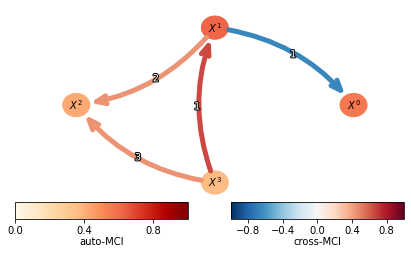

In [ ]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    )
plt.show()

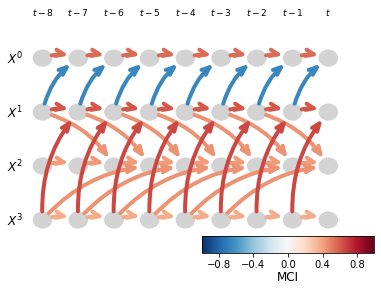

In [ ]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

While the process graph is nicer to look at, the time series graph better represents the spatio-temporal dependency structure from which causal pathways can be read off. You can adjust the size and aspect ratio of nodes with node_size and node_aspect parameters, and also modify many other properties, see the parameters of plot_graph and plot_time_series_graph.

## Have a play with changing parameters, particularly alpha and tau max, and see what happens!

# What if our relationships are not linear?

* Nonlinear conditional independence tests

If nonlinear dependencies are present, it is advisable to use a nonparametric test. Consider the following model:

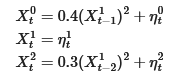

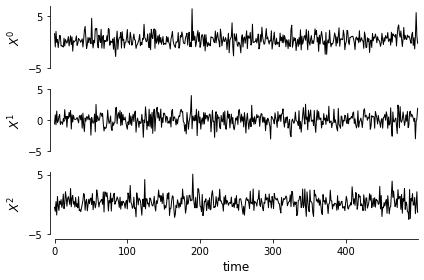

In [ ]:
np.random.seed(1)
data = np.random.randn(500, 3)
for t in range(1, 500):
    data[t, 0] += 0.4*data[t-1, 1]**2
    data[t, 2] += 0.3*data[t-2, 1]**2
dataframe = pp.DataFrame(data, var_names=var_names)
tp.plot_timeseries(dataframe) 
plt.show()

In [ ]:
pcmci_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)
results = pcmci_parcorr.run_pcmci(tau_max=2, pc_alpha=0.2, alpha_level = 0.01)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.2]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X^0$ has 1 link(s):
        ($X^0$ -2): max_pval = 0.10814, min_val = -0.072

    Variable $X^1$ has 2 link(s):
        ($X^0$ -1): max_pval = 0.08389, min_val =  0.078
        ($X^1$ -1): max_pval = 0.19371, min_val = -0.059

    Variable $X^2$ has 1 link(s):
        ($X^0$ -1): max_pval = 0.00000, min_val =  0.234

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 2
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.01:

    Variable $X^0$ has 0 link(s):

    Variable $X^1$ has 0 link(s):

    Variable $X^2$ has 1 link(s):
        ($X^0$ -1): pval = 0.00000 | val =  0.234


ParCorr here fails in two ways: (1) It cannot detect the two nonlinear links, (2) it wrongly detects a link
because it also cannot condition out a nonlinear dependency.

## GPDC

Tigramite covers nonlinear additive dependencies with a test based on Gaussian process regression and a distance correlation (GPDC) on the residuals. For GPDC no analytical null distribution of the distance correlation (DC) is available. For significance testing, Tigramite with the parameter significance = 'analytic' pre-computes the distribution for each sample size (stored in memory), thereby avoiding computationally expensive permutation tests for each conditional independence test (significance = 'shuffle_test'). GP regression is performed with sklearn default parameters, except for the kernel which here defaults to the radial basis function + a white kernel (both hyperparameters are internally optimized) and the assumed noise level alpha which is set to zero since we added a white kernel. These and other parameters can be set via the gp_params dictionary. See the documentation in sklearn for further discussion. There also exists a module (gpdc_torch.py) which exploits gpytorch for faster computations on GPUs.

In [ ]:
gpdc = GPDC(significance='analytic', gp_params=None)
pcmci_gpdc = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=gpdc,
    verbosity=0)

In contrast to ParCorr, the nonlinear links are correctly detected with GPDC:

N.B. this cell will take ~1 minute to run.

In [ ]:
results = pcmci_gpdc.run_pcmci(tau_max=2, pc_alpha=0.1, alpha_level = 0.01)

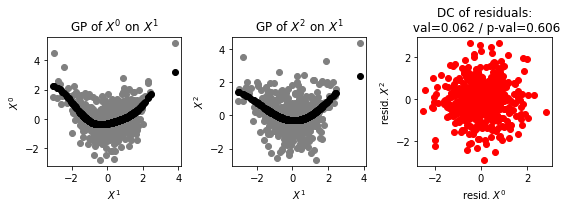

In [ ]:
array, dymmy, dummy = gpdc._get_array(X=[(0, -1)], Y=[(2, 0)], Z=[(1, -2)], tau_max=2)
x, meanx = gpdc._get_single_residuals(array, target_var=0, return_means=True)
y, meany = gpdc._get_single_residuals(array, target_var=1, return_means=True)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,3))
axes[0].scatter(array[2], array[0], color='grey')
axes[0].scatter(array[2], meanx, color='black')
axes[0].set_title("GP of %s on %s" % (var_names[0], var_names[1]) )
axes[0].set_xlabel(var_names[1]); axes[0].set_ylabel(var_names[0])
axes[1].scatter(array[2], array[1], color='grey')
axes[1].scatter(array[2], meany, color='black')
axes[1].set_title("GP of %s on %s" % (var_names[2], var_names[1]) )
axes[1].set_xlabel(var_names[1]); axes[1].set_ylabel(var_names[2])
axes[2].scatter(x, y, color='red')
axes[2].set_title("DC of residuals:" "\n val=%.3f / p-val=%.3f" % (gpdc.run_test(
            X=[(0, -1)], Y=[(2, 0)], Z=[(1, -2)], tau_max=2)) )
axes[2].set_xlabel("resid. "+var_names[0]); axes[2].set_ylabel("resid. "+var_names[2])
plt.tight_layout()

Let's look at some even more nonlinear dependencies in a model with multiplicative noise:

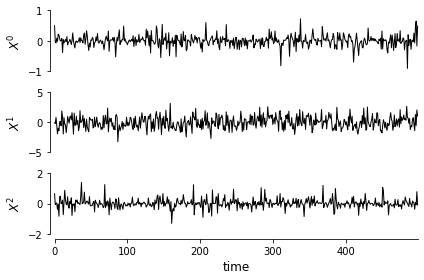

In [ ]:
np.random.seed(42)
data = np.random.randn(500, 3)
for t in range(1, 500):
    data[t, 0] *= 0.2*data[t-1, 1]
    data[t, 2] *= 0.3*data[t-2, 1]
dataframe = pp.DataFrame(data, var_names=var_names)
tp.plot_timeseries(dataframe); plt.show()

Since multiplicative noise violates the assumption of additive dependencies underlying GPDC, the spurious link
is wrongly detected because it cannot be conditioned out. In contrast to ParCorr, however, the two true links are detected because DC detects any kind of dependency:

In [ ]:
pcmci_gpdc = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=gpdc)
results = pcmci_gpdc.run_pcmci(tau_max=2, pc_alpha=0.1, alpha_level = 0.01)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Here we can see in the scatter plot, that the Gaussian Process cannot fit the dependencies and the residuals are, thus, not independent.

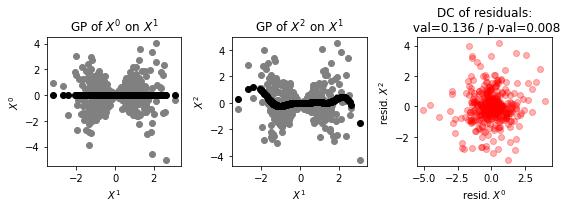

In [ ]:
array, dymmy, dummy = gpdc._get_array(X=[(0, -1)], Y=[(2, 0)], Z=[(1, -2)], tau_max=2)
x, meanx = gpdc._get_single_residuals(array, target_var=0, return_means=True)
y, meany = gpdc._get_single_residuals(array, target_var=1, return_means=True)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,3))
axes[0].scatter(array[2], array[0], color='grey')
axes[0].scatter(array[2], meanx, color='black')
axes[0].set_title("GP of %s on %s" % (var_names[0], var_names[1]) )
axes[0].set_xlabel(var_names[1]); axes[0].set_ylabel(var_names[0])
axes[1].scatter(array[2], array[1], color='grey')
axes[1].scatter(array[2], meany, color='black')
axes[1].set_title("GP of %s on %s" % (var_names[2], var_names[1]) )
axes[1].set_xlabel(var_names[1]); axes[1].set_ylabel(var_names[2])
axes[2].scatter(x, y, color='red', alpha=0.3)
axes[2].set_title("DC of residuals:" "\n val=%.3f / p-val=%.3f" % (gpdc.run_test(
            X=[(0, -1)], Y=[(2, 0)], Z=[(1, -2)], tau_max=2)) )
axes[2].set_xlabel("resid. "+var_names[0]); axes[2].set_ylabel("resid. "+var_names[2])
plt.tight_layout()

### Exercise! 

Once you have played with some parameters, what might be some problems we run into when doing causal discovery on environmental data? 

If you have some to hand, feel free to try this on some of your own data - or keep it in mind as an option in future.